## Loading Packages

In [1]:
import umap
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


## Loading and Exploring Data

Betöltöm az adatot és vetek egy első pillantást rájuk. A klaszterezést az "ad_creative" string változó alapján létrehozott vektorok segítségével, valamint a "signup_date" és az "activity" alapján hozom létre. Azt akarom megválaszolni, hogy milyen fogyasztói csoportok alakultak ki, már a hirdetések alapján.


In [2]:
url = 'https://storage.googleapis.com/superlinked-notebook-user-acquisiton-analytics/user_acquisiton_data.csv'
df = pd.read_csv(url)

In [3]:
df.iloc[0,1]
df.head(3)
#df.columns

,id,signup_date,ad_creative,activity
0,0,1693044869,Join a dynamic gaming universe where every cha...,0.295882
1,1,1694581577,Join a thriving gaming community and challenge...,1.138306
2,2,1693557423,Experience the rush of competitive gaming! Joi...,0.005266


In [4]:
df['ad_creative'].unique()

array(['Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!',
       'Join a thriving gaming community and challenge your skills against formidable opponents!',
       'Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!',
       'Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!',
       'Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!',
       'Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!',
       'Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!',
       'Embark on your gaming journey with XY

## Creating String-based Vectors

In [5]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df['ad_creative'])

In [6]:
variables = pd.DataFrame(embeddings)
variables.columns = [f"var{i+1}" for i in range(variables.shape[1])]

variables.head(5)

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var375,var376,var377,var378,var379,var380,var381,var382,var383,var384
0,0.044055,-0.037812,-0.046742,-0.058751,-0.030506,-0.007182,0.004631,-0.034763,-0.023560,0.032016,...,0.086414,0.029855,0.020063,0.117472,-0.007197,0.052057,0.083963,-0.056377,-0.104993,0.007351
1,0.028836,-0.031617,-0.009857,-0.026089,-0.040901,0.005985,0.035503,0.000702,-0.093927,0.048798,...,0.012260,0.060640,0.015442,0.103465,-0.000201,0.033084,0.081812,-0.019731,-0.088551,-0.021547
2,0.017432,-0.075919,-0.009621,-0.029945,0.006810,0.035520,0.050545,-0.017675,-0.036567,0.058980,...,0.026964,0.046765,0.022106,0.106689,0.026996,0.052468,0.061247,-0.044247,-0.111405,-0.016630
3,0.017432,-0.075919,-0.009621,-0.029945,0.006810,0.035520,0.050545,-0.017675,-0.036567,0.058980,...,0.026964,0.046765,0.022106,0.106689,0.026996,0.052468,0.061247,-0.044247,-0.111405,-0.016630
4,0.044055,-0.037812,-0.046742,-0.058751,-0.030506,-0.007182,0.004631,-0.034763,-0.023560,0.032016,...,0.086414,0.029855,0.020063,0.117472,-0.007197,0.052057,0.083963,-0.056377,-0.104993,0.007351


Ezen a ponton nem teljesen egyértelmű, hogy a "signup_date" és az "activity" skálázását hogyan lehet úgy megoldani, hogy több jelentéstartalommal bírjanak, mint a string alapján létrehozott 382 dimenziós vektorok bármelyik eleme. Arra jutottam, hogy a változókat standardizálom. Mivel a string változó értékkészlete kis elemszámú, az általuk létrehozott vektorok is merőben hasonlítanak. Ekkor újabb változó bevonásával nagyban változhat a klaszterezés eredménye. Az azonban továbbra is aggodalmam, hogy hogyan lehet jobban súlyozni egyes változókat. Itt a távolságról van szó, szóval egy változó értékeinek az csökkentése kisebb távolságokban nyílvánul meg, ami szorosabb kapcsolódást jelent az adott változó mentén.

In [7]:
scaler = StandardScaler()
variables['norm_signup_date'] = scaler.fit_transform(df[['signup_date']])
variables['norm_activity'] = scaler.fit_transform(df[['activity']])

variables.tail(5)
variables.head(5)

variables['norm_activity'].mean()
variables['norm_activity'].std()

1.0000625058599855

In [8]:
scaler = StandardScaler()

# Normalize each variable in the DataFrame
for column in variables.columns:
    variables[column] = scaler.fit_transform(variables[[column]])

In [9]:
variables['norm_signup_date'] = variables['norm_signup_date'] * 5
variables['norm_activity'] = variables['norm_activity'] * 5


In [10]:
variables.tail(5)
variables.head(5)

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var377,var378,var379,var380,var381,var382,var383,var384,norm_signup_date,norm_activity
0,1.424704,-0.370294,-1.847227,-0.438461,-0.380464,-0.260372,-1.598891,-0.522629,1.377670,-1.860425,...,1.690922,0.569877,-0.063225,-0.248921,1.000563,0.126941,-0.154848,2.053559,-8.870260,-0.251465
1,1.073374,-0.167067,0.255372,0.655636,-0.648856,0.283580,-0.527723,0.975186,-1.264749,-0.884078,...,1.497120,-0.134477,0.172357,-0.835140,0.913230,1.729156,0.325814,0.304884,-7.229645,15.532820
2,0.810110,-1.620342,0.268842,0.526450,0.582958,1.503750,-0.005803,0.199031,0.889254,-0.291663,...,1.776620,0.027674,1.088217,-0.236227,0.078238,0.657268,-0.342282,0.602471,-8.323049,-5.696660
3,0.810110,-1.620342,0.268842,0.526450,0.582958,1.503750,-0.005803,0.199031,0.889254,-0.291663,...,1.776620,0.027674,1.088217,-0.236227,0.078238,0.657268,-0.342282,0.602471,-8.583782,-0.214663
4,1.424704,-0.370294,-1.847227,-0.438461,-0.380464,-0.260372,-1.598891,-0.522629,1.377670,-1.860425,...,1.690922,0.569877,-0.063225,-0.248921,1.000563,0.126941,-0.154848,2.053559,-9.063738,-3.566641


## Clustering

In [11]:
hdbscan = HDBSCAN(min_cluster_size = 500, min_samples=15)
hdbscan_clusters = hdbscan.fit_predict(variables)

In [12]:
pd.DataFrame(hdbscan_clusters).value_counts()

 6    1785
 0    1340
 1    1312
 5     715
 3     671
-1     642
 2     533
 4     501
 7     501
dtype: int64

## Dimension Reduction

In [13]:
reducer = umap.UMAP(random_state=0, n_neighbors=10, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(variables)
bivalues = pd.DataFrame(embedding)

bivalues.head(5)


c:\Users\imre2\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,0,1
0,13.784438,-6.582511
1,3.987396,6.328078
2,13.603423,-12.890030
3,13.400729,-10.254668
4,10.607294,-5.870636


In [14]:
bivalues.columns = ['x', 'y']
bivalues['color'] = pd.DataFrame(hdbscan_clusters)
bivalues.head(5)

,x,y,color
0,13.784438,-6.582511,3
1,3.987396,6.328078,4
2,13.603423,-12.890030,0
3,13.400729,-10.254668,0
4,10.607294,-5.870636,3


## Visualization

In [15]:
bivalues['color'].unique()
bivalues['color'].max()

7

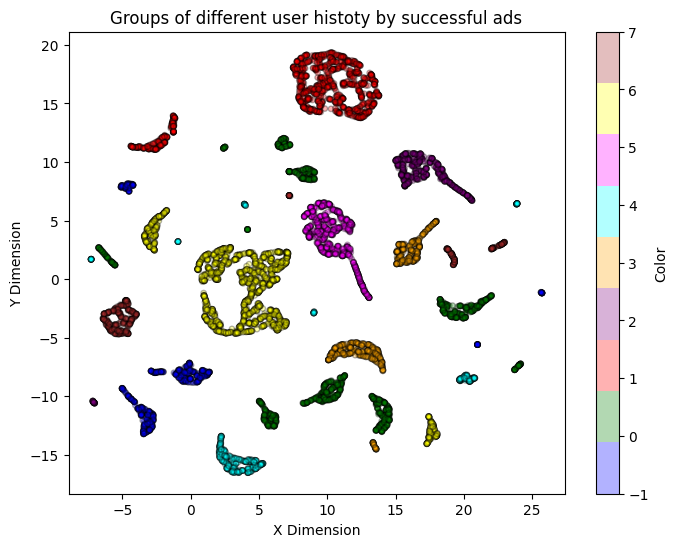

In [16]:

plt.figure(figsize=(8, 6))
cmap = ListedColormap(['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown'])
#cmap = ListedColormap(['yellow', 'orange', 'red', 'pink', 'purple', 'lightblue', 'darkblue', 'darkgreen', 'lightgreen'])
plt.scatter(bivalues['x'], bivalues['y'], c=bivalues['color'], cmap=cmap, s=15, edgecolors='k', alpha=0.3)
plt.colorbar(label='Color')
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.title('Groups of different user histoty by successful ads')
plt.show()